# Additional Datasets
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on further datasets to confirm utility. Two datasets from the [UMAP _Nat. Biotech._ paper (Becht, _et al._ 2018)](https://www.nature.com/articles/nbt.4314) are evaluated to cover some key features of our framework:__  
* Larger datasets by number of cells
* CyTOF data in addition to scRNA-seq
* Previously annotated cell clusters for local and neighborhood structural preservation
* Confirmation of findings by Becht, _et al._ using our metrics to confirm utility and resolve claim of global vs. local structure preservation by UMAP compared to t-SNE

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

---
### Samusik_01 Hematopoeitic CyTOF Dataset
[FlowRepository FR-FCM-ZZPH](https://flowrepository.org/id/FR-FCM-ZZPH)

In [3]:
sam = sc.read('../inputs/samusik_01.h5ad')

In [4]:
%%time
sam.raw = sam # save raw data before processing
arcsinh(sam, scale=1) # same transformation as Becht, et al.
sam.X = sam.layers['arcsinh_norm'].copy() # put arcsinh-transformed values in default slot

CPU times: user 29.2 ms, sys: 5.61 ms, total: 34.8 ms
Wall time: 33.7 ms


In [5]:
%time sc.tl.pca(sam, use_highly_variable=False, n_comps=2) # 2-component PCA for comparison to t-SNE and UMAP

CPU times: user 557 ms, sys: 673 ms, total: 1.23 s
Wall time: 154 ms


In [6]:
%%time
# create neighborhood graphs from PCA results and perform louvain clustering
sc.pp.neighbors(sam, n_neighbors=300, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(sam, resolution=1.0, key_added='louvain', random_state=18, copy=False)
sam.obs['clusterID'] = 'cluster_' + sam.obs['louvain'].astype(str)

CPU times: user 5min 35s, sys: 4.87 s, total: 5min 40s
Wall time: 5min 39s


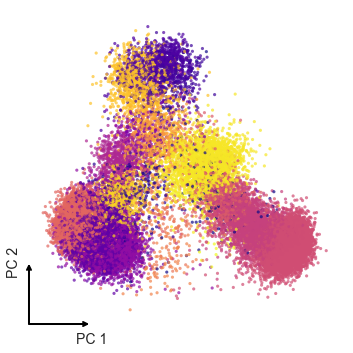

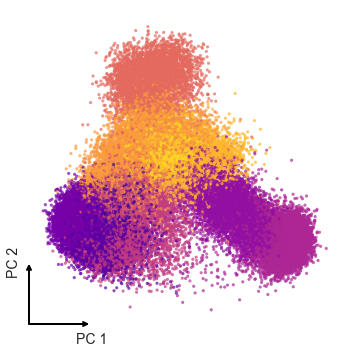

In [7]:
DR_plot(dim_name='PC').plot_IDs(sam, use_rep='X_pca', obs_col='label', pt_size=10, save_to='outputs/samusik_PCA_label.png')
DR_plot(dim_name='PC').plot_IDs(sam, use_rep='X_pca', obs_col='clusterID', pt_size=10, save_to='outputs/samusik_PCA_clu.png')

In [8]:
%time sc.tl.umap(sam, random_state=18)

CPU times: user 4min 14s, sys: 14.1 s, total: 4min 28s
Wall time: 2min 36s


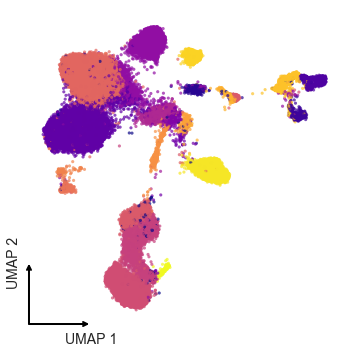

In [9]:
DR_plot(dim_name='UMAP').plot_IDs(sam, use_rep='X_umap', obs_col='label', pt_size=10, save_to='outputs/samusik_UMAP_label.png')

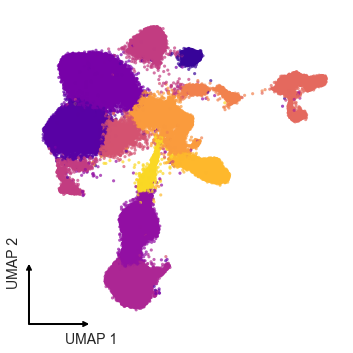

In [10]:
DR_plot(dim_name='UMAP').plot_IDs(sam, use_rep='X_umap', obs_col='clusterID', pt_size=10, save_to='outputs/samusik_UMAP_clu.png')

In [11]:
%time sc.tl.tsne(sam, random_state=18, use_rep='X', perplexity=300)

CPU times: user 47min 22s, sys: 38.1 s, total: 48min
Wall time: 15h 3min 31s


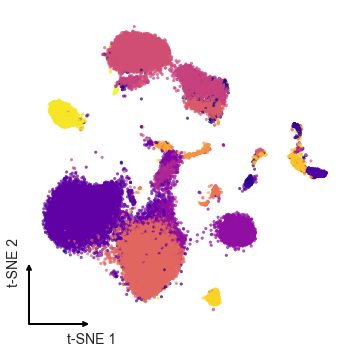

In [12]:
DR_plot(dim_name='t-SNE').plot_IDs(sam, use_rep='X_tsne', obs_col='label', pt_size=10, save_to='outputs/samusik_tSNE_label.png')

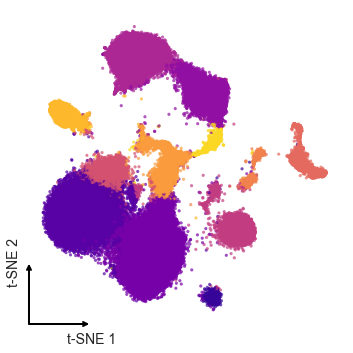

In [13]:
DR_plot(dim_name='t-SNE').plot_IDs(sam, use_rep='X_tsne', obs_col='clusterID', pt_size=10, save_to='outputs/samusik_tSNE_clu.png')

---
### Structural Preservation

**PCA**

In [ ]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(sam, latent='X_pca', native='X', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))

Calculating unique distances for native space, X


In [ ]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(sam.uns['X_norm_distances'], sam.uns['X_pca_norm_distances'])
joint_plot_distance_correlation(sam.uns['X_norm_distances'], sam.uns['X_pca_norm_distances'])

**t-SNE**

In [ ]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(sam, latent='X_tsne', native='X', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))

In [ ]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(sam.uns['X_norm_distances'], sam.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(sam.uns['X_norm_distances'], sam.uns['X_tsne_norm_distances'])

**UMAP**

In [ ]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(sam, latent='X_umap', native='X', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))

In [ ]:
plt.figure(figsize=(4,4))
plot_cumulative_distributions(sam.uns['X_norm_distances'], sam.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(sam.uns['X_norm_distances'], sam.uns['X_umap_norm_distances'])